In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [11]:
# Load the dataset
df = pd.read_csv("data/diabetic_data.csv")

# Replace '?' with NaN
df = df.replace('?', np.nan)

# Keep only <30 and >30 for readmission
df = df[df['readmitted'].isin(['<30', '>30'])]

# Drop columns with more than 40% missing data
missing_threshold = 0.4
df = df.loc[:, df.isnull().mean() < missing_threshold]

# Drop rows with missing values **only in the remaining columns**
df = df.dropna()

# Drop identifiers
df = df.drop(['encounter_id', 'patient_nbr'], axis=1, errors='ignore')

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include='object').columns.drop('readmitted')
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Binary target: 1 if readmitted within 30 days
df['readmitted'] = (df['readmitted'] == '<30').astype(int)

print(f"Dataset shape after cleaning: {df.shape}")


Dataset shape after cleaning: (27672, 1759)


In [12]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [15]:
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3877  348]
 [1149  161]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      4225
           1       0.32      0.12      0.18      1310

    accuracy                           0.73      5535
   macro avg       0.54      0.52      0.51      5535
weighted avg       0.66      0.73      0.68      5535



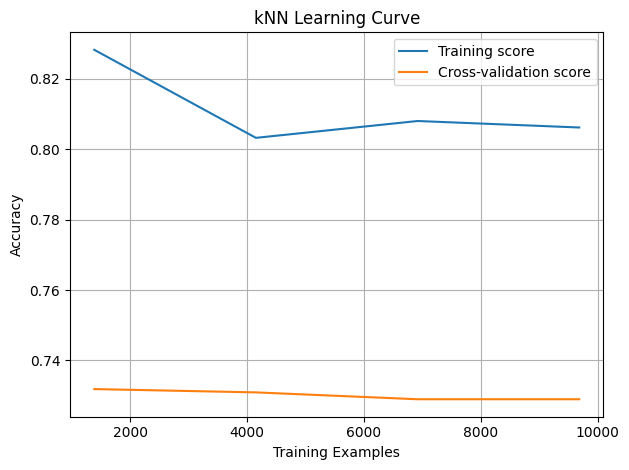

In [17]:
train_sizes, train_scores, test_scores = learning_curve(
    knn, X, y, 
    cv=2,  # Minimal CV folds
    scoring='accuracy', 
    train_sizes=[0.1, 0.3, 0.5, 0.7],  # Fewer, specific sizes
    n_jobs=1  # Single core
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.title("kNN Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()